**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

<h1><center> Using Supervised Machine Learning Models in Music Genre Classification: </center></h1><h2><center> A Focus on Extreme Gradient Boosting Method</center></h2> 

## Abstract

<p style='text-align: justify;'> <b> Multi-class classification </b> is one of the most popular problems that has been well-studied in machine learning area. In this report, we address a specific multiclass problem - the so-called **music genre classification**, of which the goal is to classify songs to their correct genre. To do so, we first visualize a given dataset of over 4000 songs from 10 genres and point out its potential problems, including imbalance and redundancy. We then examine several supervised machine learning algorithms and measure their performance accordingly, in which the best performing model is picked and improved. In overall, the best model for this problem is found to be an optimized distributed gradient boosting library named **Extreme Gradient Boosting**, and its behaviours with different parameters are examined in order to deal with dataset’s problems. Finally, we discuss some implications of this model and participate in Kaggle Competition with the tuned model.</p>

## 1. Introduction

<p style='text-align: justify;'> The goal of this report was to implement an artificial intelligence classifier, which after training would output the correct musical genre of the preprocessed song that is used as an input to the application. Apparently, this problem has been discussed before in prior researches. Indeed, Bou-Rabee, A., Go, K. & Mohan, K. (2012) presented several machine learning models with respective results for classifying musics from lyrics. In addition, Pálmason, H., Jónsson, B., Schedl, M. & Knees, P. (2017) also discussed some simple classification experiments with the help of music experts. More similarly, Neumayer, R. (n.d.) analyzed different possibilities to classify music genres and its application to mp3 files. In all, these articles help us understand that genre is a controversially multifaceted concept, and that extracting feature vectors from different songs is still a challenging task. </p>

<p style='text-align: justify;'>Fortunately, we were given a dataset to train and test our machine learning models. This dataset contained 4364 songs that were already preprocessed that consists of 264 dimensions: 168 values for the rhythm patterns (24 bands, 7 statistics), 48 values for the chroma (12 bands, 4 statistics), and 48 values for the MFCCs (12 bands, 4 statistics). In the end we should be able to find the correct label for each song from 10 different options: Pop_Rock, Electronic, Rap, Jazz, Latin, RnB, International, Country, Reggae, Blues. </p>

<p style='text-align: justify;'>To address the problem, we used different Python libraries such as numpy, matplotlib and intensively used sklearn - a machine learning library. After that, we visualized the data and extracted relevant information from it, and had some important findings, such as the label set is imbalanced, and that there are some redundant features for this project. We then implemented different machine learning models - consisting of Naive Bayes, Support Vector Machines, Random Forests and Extreme Gradient Boosting - to our dataset, evaluated their output results accordingly and segmentized them by their tuned parameters for two Kaggle competitions - Accuracy and Logloss. </p>

<p style='text-align: justify;'> Therefore, our research question is transparent: *What is the best model - in terms of accuracy and logloss evaluation method - to be applied to classify the songs to their correct genre?* At the end of this project, we hoped that answering this question would give us the tools to tackle even more challenging machine learning problems in the future, as well as the knowledge of the pipeline of such projects. Also, getting to know Kaggle is another great step to the world of data scientists.</p>

<p style='text-align: justify;'>The rest of the report is organized as follows. In section 2, the dataset is analyzed and visualized. Section 3 describes our whole approach. Section 4 shows our experimental result. In section 5, we discuss our result and this is followed by a brief conclusion. Last but not least, we present the references and appendix in section 6.  </p>

## 2. Data analysis

### 2.0. Data Import

We first start by installing the required package and importing all the necessary libraries. We intensively use scikit-learn for this report. 
<p> </p>
<font color = red> **Note for evaluators: 
    <p> </p>
<p> </p>
- For xgboost library, we try to include the link to install on both macOS and Windows. However, if you happen to be unable to install it, maybe it is better just to ignore the cells (not many) that require xgboost library.
<p> </p>
  - There are some red warnings: Please ignore them since they just warned about new version of functions in Jupyter Notebook.** </font>

In [5]:
#Installing required package & Importing files
#Please install these following packages if you have not installed yet
!pip install -U scikit-learn
!pip install --upgrade pip

#XGBoost library for XGBoost model
!pip3 install xgboost #for mac on terminal
!conda install -c conda-forge xgboost #for anaconda windows, use this link if you still struggle: https://xgboost.readthedocs.io/en/latest/build.html#installation-guide

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import itertools
from sklearn import preprocessing
import random
from sklearn.model_selection import train_test_split
import copy
from sklearn.metrics import confusion_matrix
import sklearn.feature_selection
import warnings
warnings.filterwarnings('ignore') #To disable unnecessary warnings

Next, we load the data for using. We notice that the label is encoded from [1...10], which is difficult for Python to classify correctly. That is why we encode the label into [0,...,9] to be more Pythonic.

Also, the function *label_matrix* is to convert a 1-column matrix into a label matrix of 10 columns. This function is intensively used to calculate LogLoss.

In [3]:
#Load the data and cleanup
X = (pd.read_csv("train_data.csv", header = None)).values #Import the full feature, shape: 4363 x 264 
y = (pd.read_csv("train_labels.csv", header = None)).values 
y = np.reshape(y,(y.shape[0],1)) #Import & reshape the data labels, shape: 4363 x 1 
N = X.shape[0] #Get N = 4363

#1) Encoding Dataset from (1 ... 10) into (0 ... 9)
le = preprocessing.LabelEncoder()
le.fit(y)
Y = le.transform(y) #Shape Y: 4363 x 1 (but the label data is now 0 ... 9 )

def label_matrix(Y): #Convert the (N,1) label vector into (N,10) label matrix
    Ymatrix = np.zeros((Y.shape[0],10))  
    for i in range(len(Y)):
        for j in range(10):
            if Y[i] == j:
                Ymatrix[i,j] = 1
    return Ymatrix

Ymatrix = label_matrix(Y)

### 2.1. Analysis of the Input Data

### 2.1.1. Labels

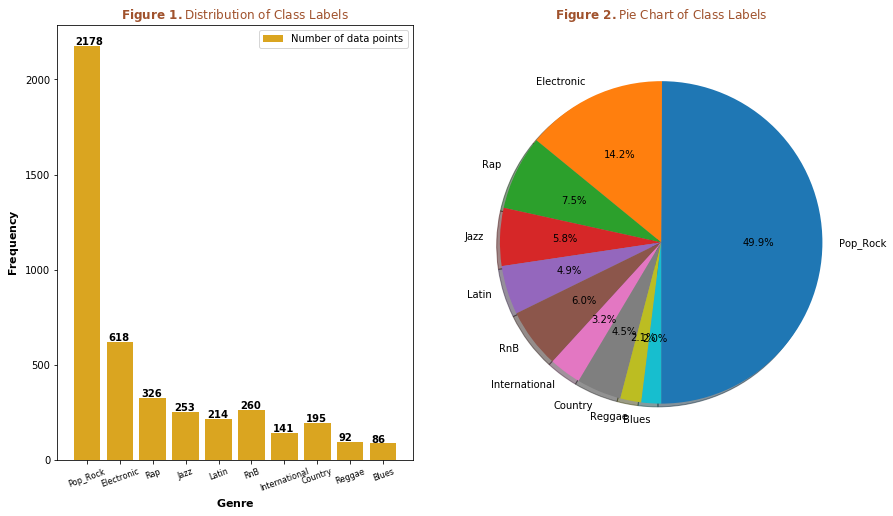

In [4]:
##Histogram Label
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
bins = range(0,10) 
values = np.bincount(Y) #To get the number of songs for each type from 0 -> 9
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups

#Bar Chart 
definitions = ['Pop_Rock', 'Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']
axes[0].bar( bins, values, color = "goldenrod", label = 'Number of data points', tick_label = definitions)
for i, v in enumerate(values):
    axes[0].text(i -0.35, v + 6, str(v), color='black', fontweight='bold')
axes[0].set_ylabel (r'$\bf{Frequency}$',size = 11)
axes[0].set_xlabel (r'$\bf{Genre}$',size = 11)
axes[0].set_title(r'$\bf{Figure\ 1.}$Distribution of Class Labels', color = "sienna")
axes[0].set_xticklabels(definitions,  size = 8, rotation = 20)
axes[0].legend()

#Pie Chart
axes[1].pie(values, labels = definitions,  autopct='%1.1f%%', shadow=True, startangle=270)
axes[1].set_title(r'$\bf{Figure\ 2.}$Pie Chart of Class Labels', color = "sienna")
axes[1].axis('equal')
plt.show()

From **Figure 1** and **Figure 2** above, we can see that the that the dataset is <font color = brown> **heavily imbalanced** </font>: Almost half of the songs belong to Pop_Rock, and the next biggest group, Electronic, has almost twice the number of songs as the 3rd biggest group. This is one of the problem we try to solve in the next part.

### 2.1.2. Features Visualization
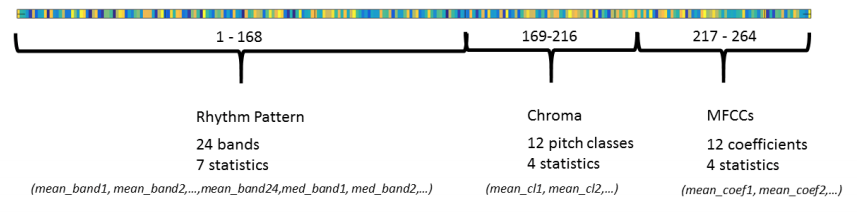

Each sample of our dataset is made of 264 different features. The first 168 values of our feature vectors describe the Rhythm of the song, next 48 values the Chroma of the song, and the last 48 values the MFCCs of the song.

The features are explained in the following way in the project description:

<p style='text-align: justify;'>*“The features used include the first 12 MFCCs (Mel Frequency Cepstral Coefficients), chroma values, and rhythm patterns. In short, the MFCCs provide a spectrum of the spectrum of an audio file, showing the overall shape of the frequency content and can be used to describe timbre. The chroma features are a condensed representation of the audio spectrum, where the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave used in most western music. Thus the chroma can be used to analyze pitch (melody and harmony). Finally, the rhythm patterns describe how much modulation is happening on certain ranges of the frequency spectrum.”*</p>

In the following, we attempt to **visualize the average value of the feature space across genres**.

#### Rhythm Features

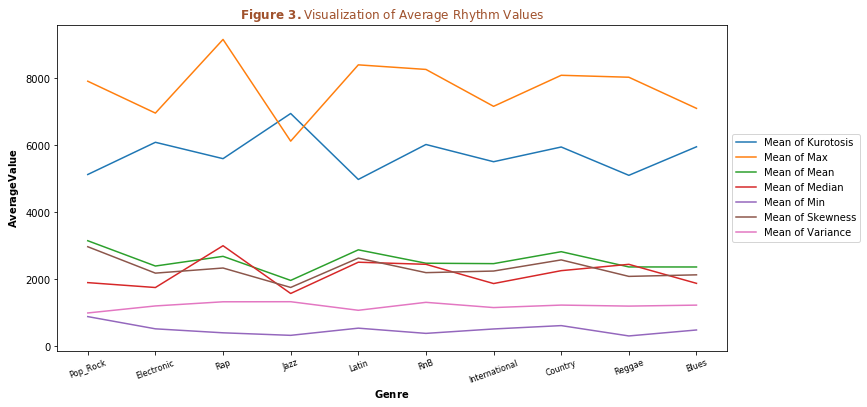

In [5]:
n_cols = X.shape[1]
#return a vector where those features that are same accross the datset are True

df = pd.DataFrame(X)
df_rhythm =       df.loc[:, 0:167]
rhythm_mean =     df_rhythm.loc[:, 0:23].mean(axis=1)
rhythm_median =   df_rhythm.loc[:, 24:47].mean(axis=1)
rhythm_variance = df_rhythm.loc[:, 48:71].mean(axis=1)
rhythm_kurtosis = df_rhythm.loc[:, 72:95].mean(axis=1)
rhythm_skewness = df_rhythm.loc[:, 96:119].mean(axis=1)
rhythm_min =      df_rhythm.loc[:, 120:143].mean(axis=1)
rhythm_max =      df_rhythm.loc[:, 144:].mean(axis=1)

rhythm = pd.DataFrame(np.column_stack((Y,rhythm_mean, rhythm_median, rhythm_variance, rhythm_kurtosis, \
                                       rhythm_skewness, rhythm_min, rhythm_max)))
rhythm.columns= ["Label", "Mean", "Median", "Variance", "Kurtosis", "Skewness", "Min", "Max"]
rhythm_pivot = pd.pivot_table(rhythm, values=["Mean", "Median", "Variance", "Kurtosis", "Skewness", "Min", "Max"], columns=['Label'], aggfunc=np.mean)

#Plotting the rhythm features
my_plot = np.transpose(rhythm_pivot).plot(kind='line', figsize=(12, 6))

my_plot.set_xlabel(r'$\bf{Genre}$')
my_plot.set_ylabel(r"$\bf{Average Value}$")
my_plot.set_title(r"$\bf{Figure\ 3.}$Visualization of Average Rhythm Values", color = "sienna")
r_pivot_table_columns = ["Mean of Kurotosis", "Mean of Max", "Mean of Mean", "Mean of Median", "Mean of Min", "Mean of Skewness", "Mean of Variance"]

my_plot.set_xticks(np.arange(0,10,1))
my_plot.set_xticklabels(definitions,  size = 8, rotation = 20)
my_plot.legend(labels = r_pivot_table_columns, loc='center left', bbox_to_anchor=(1, 0.5))

<p style='text-align: justify;'> The rhythm is represented by 24 bands, and each of them have 7 different statistical values: mean, median, variance, kurtosis, skewness, min and max. **Figure 3** above visualizes the rhythm statistics, on the x-axis are the 10 different labels, and the values correspond to the mean of each song of those statics across each band on the Rhythm. In this plot, we can see that the mean of each statistic differ quite a bit from genre to genre. </p>

<p style='text-align: justify;'> However, the graph also tells that there is a great possibility that these statistics correlate/covariate to each other across genres: More specifically, one can see that the average values of mean and skewness are almost similar for all genres. This might be a hint that the feature set can **be redundant and thus have potential to be optimized**. </p>

#### Chroma Features

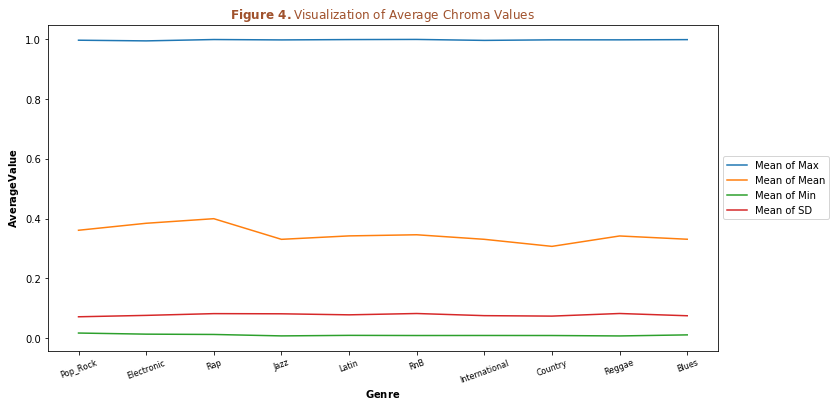

In [6]:
# Chroma features
df_chroma = df.loc[: , 168:215]
as_array = df_chroma.values

chroma_mean = as_array[:, 0:11].mean(axis=1)
chroma_sd =   as_array[:, 12:23].mean(axis=1)
chroma_min =  as_array[:, 24:35].mean(axis=1)
chroma_max =  as_array[:, 36:].mean(axis=1)

#arra = df_chroma.values
chroma = pd.DataFrame(np.column_stack((Y, chroma_mean, chroma_sd, chroma_min, chroma_max)))
chroma.columns= ["Label", "Mean", "SD", "Min", "Max"]

chroma_pivot = pd.pivot_table(chroma, values=["Mean", "SD", "Min", "Max"], columns=['Label'], aggfunc=np.mean)

#Plotting the chroma features
my_plot = np.transpose(chroma_pivot).plot(kind='line', figsize=(12, 6))

my_plot.set_xlabel(r'$\bf{Genre}$')
my_plot.set_ylabel(r"$\bf{Average Value}$")
my_plot.set_title(r"$\bf{Figure\ 4.}$Visualization of Average Chroma Values", color = "sienna")
c_pivot_table_columns = ["Mean of Max", "Mean of Mean", "Mean of Min", "Mean of SD"]
definitions = ['Pop_Rock', 'Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']

my_plot.set_xticks(np.arange(0,10,1))
my_plot.set_xticklabels(definitions,  size = 8, rotation = 20)
my_plot.legend(labels = c_pivot_table_columns, loc='center left', bbox_to_anchor=(1, 0.5))

**Figure 4** visualizes average statistics over each of their bag of frame on Chroma features. With this visualization, the mean values of Chroma statistics are much more similar across all of the genres.

#### MFCC Features

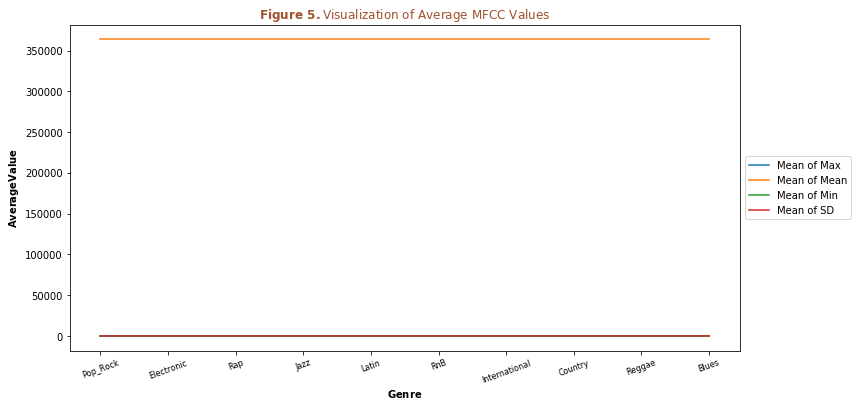

In [7]:
#mfcc features
df_mfcc = df.loc[ :,216:263]
as_array = df_mfcc.values

mfcc_mean = as_array[:, 0:11].mean(axis=1)
mfcc_sd = as_array[:, 12:23].mean(axis=1)
mfcc_min = as_array[:, 24:35].mean(axis=1)
mfcc_max = as_array[:, 36:].mean(axis=1)

mfcc = pd.DataFrame(np.column_stack((Y, mfcc_mean, mfcc_sd, mfcc_min, mfcc_max)))
mfcc.columns = ["Label", "Mean", "SD", "Min", "Max"]

mfcc_pivot = pd.pivot_table(mfcc, values=["Mean", "SD", "Min", "Max"], columns=['Label'], aggfunc=np.mean)

#Plotting the MFCC features
my_plot = np.transpose(mfcc_pivot).plot(kind='line', figsize=(12, 6))

my_plot.set_xlabel(r'$\bf{Genre}$')
my_plot.set_ylabel(r"$\bf{Average Value}$")
my_plot.set_title(r"$\bf{Figure\ 5.}$Visualization of Average MFCC Values", color = "sienna")
m_pivot_table_columns = ["Mean of Max", "Mean of Mean", "Mean of Min", "Mean of SD"]
definitions = ['Pop_Rock', 'Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']

my_plot.set_xticks(np.arange(0,10,1))
my_plot.set_xticklabels(definitions,  size = 8, rotation = 20)
my_plot.legend(labels = m_pivot_table_columns, loc='center left', bbox_to_anchor=(1, 0.5))

**Figure 5** visualizes average statistics over each of their bag of frame on MFCC. However, the values seem to be conflicted, since the mean of each genre is so much higher than any other statistic, and manual inspection into the dataset made us to suspect that there might be something wrong with the dataset.

### 2.2. Dealing with Dataset Problems

### 2.2.1. Imbalanced Dataset

<p style='text-align: justify;'> Bilogur, A. (2018) introduced some methods to deal with an imbalanced dataset. Due to limited resources, we decide to proceed with oversampling only.

Function *add_others* below implements the oversampling by taking random samples out of the dataset, and if they belonged to any other group than Pop_Rock, we made a duplicate of the song and added it into the dataset.

As an example of adding 2000 random songs, it can be seen that the distribution is now less imbalanced, and the weights of songs different from Pop_Rock have been increased. </p>

In [8]:
# Analyzing Features
#Oversampling and functions to reduce the dataset: adds duplicates that are not Pop_Rock
def add_others(x, y, n):
    random.seed(1)
    N = x.shape[0]
    D = x.shape[1]
    expanded_X = x
    expanded_Y = y
    count = 0
    flag = True
    while flag:
        i = random.randint(0,N)
        if expanded_Y[i] != 0:
            label = expanded_Y[i]
            datavector = np.reshape(expanded_X[i, ],(1,D))
            count += 1
            expanded_Y = np.append(expanded_Y,label)
            expanded_X = np.append(expanded_X,datavector, 0)
            if count == n:
                flag = False
    print("Added ",count, " random non pop-rock samples")
    return expanded_X, expanded_Y

Added  2000  random non pop-rock samples


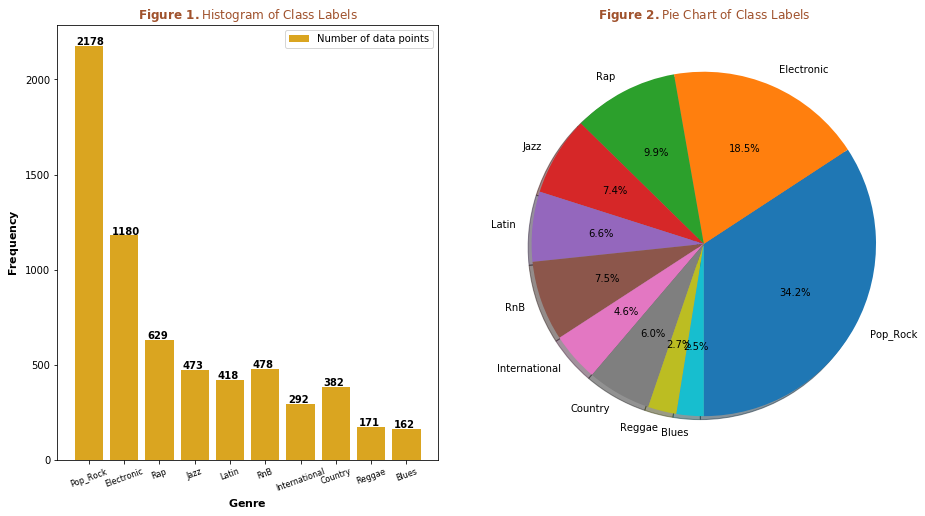

In [9]:
#WARNING: This code takes 30 seconds
def analyze_labels(yvector):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    bins = range(0,10) 
    definitions = ['Pop_Rock', 'Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']
    values = np.bincount(yvector) #To get the number of songs for each type from 0 -> 9

    width = 0.75 # the width of the bars 
    ind = np.arange(len(yvector))  # the x locations for the groups

    #Bar Chart 
    axes[0].bar( bins, values, color = "goldenrod", label = 'Number of data points', tick_label = definitions)
    for i, v in enumerate(values):
        axes[0].text(i -0.35, v + 6, str(v), color='black', fontweight='bold')
    axes[0].set_ylabel (r'$\bf{Frequency}$',size = 11)
    axes[0].set_xlabel (r'$\bf{Genre}$',size = 11)
    axes[0].set_title(r'$\bf{Figure\ 1.}$Histogram of Class Labels', color = "sienna")
    axes[0].set_xticklabels(definitions,  size = 8, rotation = 20)
    axes[0].legend()

    #Pie Chart
    axes[1].pie(values,labels = definitions,  autopct='%1.1f%%', shadow=True, startangle=270)
    axes[1].set_title(r'$\bf{Figure\ 2.}$Pie Chart of Class Labels', color = "sienna")
    axes[1].axis('equal')
    plt.show()
    
oversamppled_x, oversampled_y = add_others(X,Y,2000)
analyze_labels(oversampled_y)   

### 2.2.2. Data Redundancy

#### Meaningless Features

<p style='text-align: justify;'> When we visually studied the dataset, we noticed that few of the features seemed to have same values across the feature length, and after we examined the dataset mathematically we found out that all of the songs had the same values on four different features, thus making those values meaningless as we tried to find out the best solutions for our problem. Those are the first 4 columns in MFCC features.</p>

Therefore, we have created a new feature matrix, so-called **X_reduced**, which is used for later models.

In [10]:
#Function that checks if any of the columns has same value accross the dataset
def check_meaningless_features(X):
    max = np.max(X, axis = 0)
    min = np.min(X, axis = 0)
    count = 0
    for i in range(len(max)):
        if max[i] == min[i]:
            print("This feature is meaningless: " + str(i))
            count += 1
    return count

In [11]:
##Check meaniningless features and remove them
#Remove columns from the dataset
def remove_columns(x, columns):
    panda_dframe = pd.DataFrame(x)
    panda_dframe = panda_dframe.drop(columns, axis=1)
    return panda_dframe.values

check_meaningless_features(X)
X_reduced = remove_columns(X, [216,217,218,219])

This feature is meaningless: 216
This feature is meaningless: 217
This feature is meaningless: 218
This feature is meaningless: 219


#### Feature Selection

As we tried to find the best algorithms and best set of relevant features from the dataset, we used K-best feature selection algorithm, which reduces the dataset into k features that have the maximum relevance with the target variable.

In [12]:
#From sklearn select k-best features, and returns the reduced training and testing datasets
#Prints the visualization of the features that were left out

def select_k_best(X,Y, k):
    panda_X = pd.DataFrame(X)
    panda_Y = pd.DataFrame(Y)

    select = sklearn.feature_selection.SelectKBest(k=k)
    selected_features = select.fit(panda_X, panda_Y )
    indices_selected = selected_features.get_support(indices=True)
    colnames_selected = [panda_X.columns[i] for i in indices_selected]

    X_reduced_k = panda_X[colnames_selected]
    
    mask = select.get_support()
    plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
    plt.show()

    return X_reduced_k

For example, with K = 150, our features vectors were reduced to the following features:

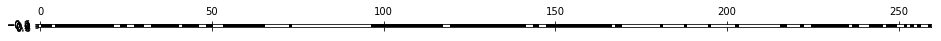

In [13]:
X_reduced_k = select_k_best(X_reduced,Y,150)

Where, black represents features that are relevant, and white represent those features that the algorithm found the least relevant. We will apply this method to the last step (will be explained in **Section 3**) in order to optimize the model.

## 3. Methods and Experiments

Since there is no restriction on possible classifiers or libraries, the whole approach is developed according to our researches and experiments. The figure below summarizes our strategy for solving this problem:

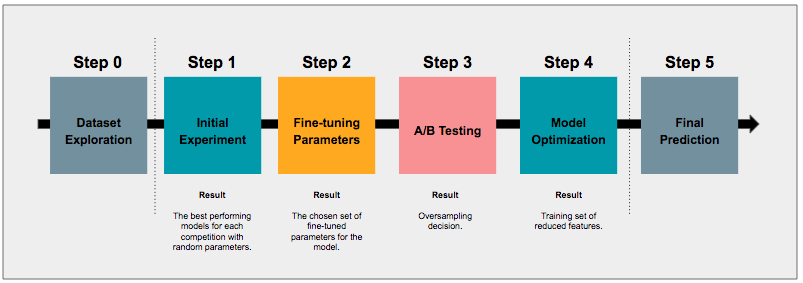

**Step 0: Dataset Exploration**

From previous step, we have visualized the data and realized some issues in the dataset:
- Imbalanced dataset.
- Potential redundancy in features. 

These problems will be dealed consequently in the following steps.

**Step 1: Initial Experiment**

<p style='text-align: justify;'>This is a multiclass classification problem. Since there is no “perfect” algorithm that performs well at any given problem, it is first decided to (a) attempt several experiments with different classifiers and (b) evaluate their initial results first before exploring further: </p>

*(a) Attempted Classifiers:*

There are several classifiers that could be a good candidate for a supervised multi-class learning problem when the target label is non-linear.

<p style='text-align: justify;'>In a similar analysis of music genre classification, Bou-Rabee, A., Go, K. & Mohan, K. (2012) found that Naive Bayes (NB) algorithms consistently provided highest accuracy, then came Super Vector Machine (SVM),  Random Forests,  Softmax respectively in a decreasing order of performance. Besides, in another research done by Li, S. (2018) on multi-class text classification, the top 3 performers from the prior paper, which are NB, SVM and Random Forests, were also used. Surely their findings do not entirely correspond to our problem, but it has shed some light to a certain extent of how to deal with this problem. We have done some researches and concluded that they are indeed right contenders to benchmark our problem. For your convenience, below are some brief descriptions of each classifier which we try to avoid unnecessary complex mathematical formulas: </p>

- **Multinomial NB**: An application of Bayes' theorem to classify objects with respect to the probability of an event. 
- **Multi-class SVM**: A representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible
- **Random Forests**: A construction of a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. 

<p style='text-align: justify;'>In addition, we came across an article from Harasymiv, V. (2015), who shared that Extreme Gradient Boosting (XGBoost) is a common choice for the winning model in Kaggle competition. Thus, we would like to experiment it as well. While the other three above-mentioned models are popular, XGBoost might not be familiar to some; thus, for your convenience, we would like to give a brief introduction about XGBoost: </p>

- **XGBoost** is *“an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable”*. XGBoost is built on Gradient Boosting algorithm, which is an ensemble technique that combines several weak learners to deliver a better accuracy. More precisely, this method gives different weights to each classifier being combined over iterations based on their accuracy. XGBoost has different advantages in parallel processing, regularization and built-in cross validation.

<p style='text-align: justify;'>For further explanation of algorithms, the references are included in case of interests. At this step, we still do not pay attention to the parameters of each model, which means we use random parameters to execute the model and evaluate it accordingly.</p>

*(b) Evaluation & Selection Methodology:*

With each of the above-mentioned model, there are 2 ways to evaluate the performance. 

 - **Splitting between Training/Validation:**
Firstly, the original training data is splitted into two smaller sets of training:validation set with the ratio 4:1. The purpose is to get a rough feeling of the performance of each model quickly yet somehow accurately. 
To retain the same results for later use, we pick a random state of 1 for all models. Each model after being executed will result in an accuracy and log-loss for that random state. A *confusion matrix* is also embedded to at this step to better clarify the performance of a model. 

- **Cross Validation (CV) 5-Folds: **
Bearing in mind that a single random state might not sufficiently tell the precise performance of a model, we decide to simultaneously implement cross validation 5-folds for all models. The result of this step is an average accuracy/log-loss with its respective standard deviation. 

Having results from both evaluation methodologies, we will examine the performance and select the best models on the basis of accuracy (highest accuracy) and log-loss (lowest log-loss) for further implementation in the next steps.

It is also worth mentioning that within the scope of this analysis, we intensively use Scikit-learn library for the above-mentioned model.

   <font color = brown>**>> Result from this step: The best performing models for each competition with random parameters.**

**Step 2: Fine-tuning Parameters**

Parameters play an important role in the model’s performance. Every model has different set of parameters to be tuned and adjusted, and some libraries support the model tuning by GridSearchCV or RandomizedSearchCV, in which CV is already integrated to evaluate its model’s performance. 

Since this step depends on which model being used, explanations - for instance: parameters, tuning values, etc - will be made further in **Section 4**. 

<font color = brown> **>> Result from this step: The chosen set of fine-tuned parameters for the model.**

**Step 3: A/B Testing between Oversampled/Original Dataset**

<p style='text-align: justify;'> As explained in **Section 2**, we have written a function in which oversampling method can be implemented on the original dataset. Since we would like to understand whether oversampling helps to improve the performance of the chosen models, we decide to do it by **A/B testing**, meaning that we run these models one more time upon the oversampled dataset. Except from Pop_Rock, we oversample a total of 2000 to the original dataset. Since it distributed the oversampling size randomly to other 09 labels except Pop_Rock, the oversampled amount for each class can be expected to be ~222 per each class, which is a reasonable number (not too many to be over-duplicated, not too low to be ineffective).
 </p>

At this step, we re-examine the performance of the model and compare its performance to that of the original dataset and decide whether or not we should go with this oversampling method in order to deal with this imbalanced dataset.


<font color = brown> **>> Result from this step: Oversampling decision. **

**Step 4: Model Optimization**
    
With oversampling decision, we will optimize the model by reducing the number of features. From **Feature Selection ( Section 2)**, we already have an list of features by their importance; thus, we will test the best model with different number of most relevant features [100, 150, 200, 250] respectively by its rank of importance.

Also, it is necessary to note that we decided to do this step after all the tuning and A/B testing part because the optimization will perform differently with different models. Having the training set optimized focusedly on a specific model would be more efficient. In addition, in terms of resource-wise, the size of this dataset allows us to follow this strategy since it is not exceedingly huge. 

<font color = brown> **>> Result from this step: An optimized model with a training set of reduced features. **

**Step 5: Final Prediction**

The test set is loaded and we let the best model do its job.

<font color = brown> **>> Result from this step: Predicted label lists that are used for Kaggle competition**

Below are functions that are used regularly throughout the experiments in **Section 4**. For your convenience, they are explained as follows:

- Function *cal_accuracy*: To calculate accuracy rate. 
- Function *cal_logloss*: To calculate log loss.
- Function *confusionmatrix*: To calculate confusion matrix and draw the CM table.

In [14]:
#Define Objective Functions:        
##Accuracy
def cal_accuracy(Y,Y_hat):
    m = 0
    N = Y.shape[0]
    for i in range(N):
        if Y[i] == Y_hat[i]:
            m = m + 1
    accuracy = round(m/N*100, 3)
    return accuracy

##Logloss
def cal_logloss(Ymatrix, Y_hatprob):
    from sklearn.metrics import log_loss
    logloss = round(log_loss(Ymatrix,Y_hatprob),3)
    return logloss

##Confusion Matrix
def confusionmatrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

And:
- Function *modelfit*: To train and fit model to a certain dataset (applied for NB, SVM, RF). There are several decisions:
    - *performCV*: Whether or not the model performs Cross Validation (defaul folds: 5).
         - If not, the model takes Splitting between Training/Validation method as a validation method. Confusion Matrix is activated. 
         - In case of Cross Validation, we set the report to print out average value of Accuracy and Logloss with 2 times of Standard Deviation for all executed folds. 
    - *oversampling*: Whether or not the model perform Oversampling (default size: 1000). If not, the model takes the dataset without oversampling.
- Function *modelfit_xgb*: Apply explicitly for XGBoost, since the syntax is different. Besides *performCV* and *oversampling* decisions, it also defines number of boosting rounds (*num_round*)

In [15]:
#Define function to run model NB, SVM, RF:
##Including in the function is Cross Validation & Oversampling decisions
def modelfit(classifier, X , Y, performCV = False, cv_folds = 5, testsize = 0.2, oversampling=False, oversampling_size=1000):
    print ('\033[1m' + "\nModel Report: " + '\033[0m')
    
    if performCV == False:
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = testsize, random_state = 10 )
        
        if oversampling:
            X_train, Y_train = add_others(X_train, Y_train, oversampling_size)
            
        classifier.fit( X_train, Y_train)
        Y_pred = classifier.predict(X_val)
        Y_hatprob1 = classifier.predict_proba(X_val)
        Y_valmatrix = label_matrix(Y_val)
        cnf_matrix=confusion_matrix(Y_val,Y_pred)
        confusionmatrix(cnf_matrix,classes=definitions,title='Confusion matrix')
        
        #Check Target:
        acc1 = cal_accuracy(Y_val,Y_pred)
        logloss1 = cal_logloss(Y_valmatrix, Y_hatprob1)
        print("Without Cross Validation - Split Training/Validation set as 4:1 :")
        print("\t1. The Accuracy of this model is " + str(acc1) + " %")
        print("\t2. The Logloss of this model is " + str(logloss1))
    else:
        from sklearn.model_selection import cross_val_score
        if oversampling:
            X, Y = add_others(X, Y, oversampling_size)  
        logloss1 = cross_val_score(classifier, X, Y, cv = cv_folds, scoring = 'neg_log_loss')
        acc1 = cross_val_score(classifier, X, Y, cv = cv_folds)
        print("With Cross Validation - (CV " + str(cv_folds) + " folds) :")
        print("\t1. The average Accuracy of this model is : %0.2f (+/- %0.2f)" % (acc1.mean() * 100, acc1.std() * 2 * 100) + "%")
        print("\t2. The average Logloss: %0.2f (+/- %0.2f)" % (logloss1.mean() * -1, logloss1.std() *2))

In [16]:
### Define function to run model XGBoost: 
def modelfit_xgb(classifier, X, Y, param, num_round = 50, performCV = False, cv_folds = 5, oversampling=False, oversampling_size=1000):
    import xgboost as xgb
    print ('\033[1m' + "\nModel Report: " + '\033[0m')

    if performCV == False:
        print("Without Cross Validation - Split Training/Validation set as 4:1 :")
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 10 )
        if oversampling:
            X_train, Y_train = add_others(X_train, Y_train, oversampling_size)     
    
        xg_train = xgb.DMatrix(X_train, label=Y_train)
        xg_val = xgb.DMatrix(X_val, label=Y_val)
        watchlist = [(xg_train, 'train'), (xg_val, 'val')]

        #get loglos                                  
        bst_proba = classifier.train(param, xg_train, num_round, watchlist)
        Yproba = bst_proba.predict(xg_val).reshape(X_val.shape[0], 10)
        Y_valmatrix = label_matrix(Y_val)
        logloss = cal_logloss(Y_valmatrix, Yproba)
    
        #get accuracy
        Ypred = np.zeros((Yproba.shape[0],1))
        for i in range(Yproba.shape[0]):
            Ypred[i] = Yproba[i].argmax()  
        accu = cal_accuracy(Y_val, Ypred)

        #confusion_matrix
        cnf_matrix=confusion_matrix(Y_val,Ypred)
        confusionmatrix(cnf_matrix,classes=definitions,title='Confusion matrix')
        print('\t1. The Accuracy of this model is %.2f%%' % (accu))
        print("\t2. The Logloss of this model is " + str(logloss))
    
    else:
        print("With Cross Validation - (CV " + str(cv_folds) + " folds) :")
        if oversampling:
            X, Y = add_others(X, Y, oversampling_size)  
        xg_train = xgb.DMatrix(X, label=Y)
        print("\t1. Accuracy:")
        bst = xgb.cv(param, xg_train, num_round, nfold = cv_folds, verbose_eval = True, metrics = {'merror'})
        print(" --- The average Accuracy of this model is : %0.2f (+/- %0.2f)" % ((100 - bst['test-merror-mean'].mean() * 100), bst['test-merror-mean'].std() * 2 * 100) + "%")
        print("\t2. Loglos:")
        bst_proba = xgb.cv(param, xg_train, num_round, nfold = cv_folds, verbose_eval = True, metrics = {'mlogloss'})
        print(" --- The average Logloss: %0.2f (+/- %0.2f)" % (bst_proba['test-mlogloss-mean'].mean(), bst_proba['test-mlogloss-mean'].std() *2))

## 4. Results

In accordance with our methodology above, in this section we will summarize the results of the experiments steps by steps. Confusion matrix/Cross Validation result is included in every execution for a better view of results.

<font color = red> **Note: There are some cells that would take some time to finish. Please pay attention to the WARNING!**

### 4.1. Step 1: Initial Experiment 

**4.1.1. Model 1: Multinomial NB**

- Execution time: Instantly.
- Performance: See below.


Model Report: 
Without Cross Validation - Split Training/Validation set as 4:1 :
	1. The Accuracy of this model is 52.463 %
	2. The Logloss of this model is 1.527

Model Report: 
With Cross Validation - (CV 5 folds) :
	1. The average Accuracy of this model is : 51.71 (+/- 0.88)%
	2. The average Logloss: 1.56 (+/- 0.07)


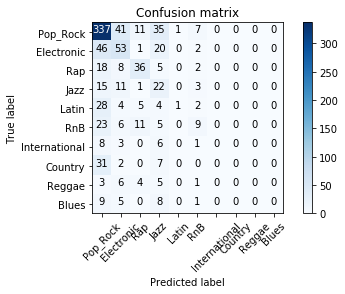

In [17]:
from sklearn.naive_bayes import MultinomialNB
nb_trial = MultinomialNB()
min_max_scaler = preprocessing.MinMaxScaler() #Need to scale for NB [0,1] because NB requires the data to be non-negative
X_scaled = min_max_scaler.fit_transform(X_reduced)

modelfit(nb_trial, X_scaled, Y) #No Cross Validation
modelfit(nb_trial, X_scaled, Y, performCV = True, cv_folds = 5) #With Cross Validation

**4.1.2. Model 2: Multiclass SVM**
- Execution time: ~ 15 minutes. 
- Performance: See below.


Model Report: 
Without Cross Validation - Split Training/Validation set as 4:1 :
	1. The Accuracy of this model is 49.485 %
	2. The Logloss of this model is 1.721

Model Report: 
With Cross Validation - (CV 5 folds) :
	1. The average Accuracy of this model is : 49.92 (+/- 0.24)%
	2. The average Logloss: 1.71 (+/- 0.01)


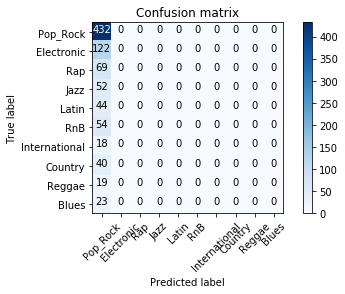

In [20]:
#WARNING: This code takes ~15 minutes to run
from sklearn import svm
svm_trial = svm.SVC(gamma=1, probability = True)

modelfit(svm_trial, X_reduced, Y) #No Cross Validation
modelfit(svm_trial, X_reduced, Y, performCV = True, cv_folds = 5) #With Cross Validation

**4.1.3. Model 3: Random Forests**

- Execution time: 30 seconds
- Performance: See below.



Model Report: 
Without Cross Validation - Split Training/Validation set as 4:1 :
	1. The Accuracy of this model is 59.908 %
	2. The Logloss of this model is 2.184

Model Report: 
With Cross Validation - (CV 5 folds) :
	1. The average Accuracy of this model is : 58.86 (+/- 1.93)%
	2. The average Logloss: 2.79 (+/- 0.15)


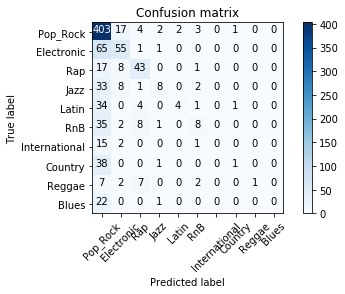

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_trial = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 10)

modelfit(rf_trial, X_reduced , Y) #No Cross Validation
modelfit(rf_trial, X_reduced, Y, performCV = True, cv_folds = 5) #With Cross Validation

**4.1.4. Model 4: Extreme Gradient Boosting**

- Execution time: ~ 7 minutes.
- Performance: See below

We chose a number of boosting rounds of 50, which means that the model keeps improving 49 times from the first round.


Model Report: 
Without Cross Validation - Split Training/Validation set as 4:1 :
[0]	train-merror:0.265043	val-merror:0.442153
[1]	train-merror:0.214327	val-merror:0.424971
[2]	train-merror:0.194842	val-merror:0.426117
[3]	train-merror:0.182235	val-merror:0.414662
[4]	train-merror:0.17106	val-merror:0.413517
[5]	train-merror:0.161891	val-merror:0.41008
[6]	train-merror:0.148997	val-merror:0.404353
[7]	train-merror:0.138968	val-merror:0.407789
[8]	train-merror:0.131805	val-merror:0.405498
[9]	train-merror:0.125215	val-merror:0.41008
[10]	train-merror:0.118052	val-merror:0.41008
[11]	train-merror:0.110602	val-merror:0.406644
[12]	train-merror:0.105731	val-merror:0.405498
[13]	train-merror:0.102006	val-merror:0.408935
[14]	train-merror:0.098854	val-merror:0.406644
[15]	train-merror:0.094556	val-merror:0.399771
[16]	train-merror:0.089685	val-merror:0.403207
[17]	train-merror:0.084527	val-merror:0.402062
[18]	train-merror:0.077937	val-merror:0.400916
[19]	train-merror:0.073639	val-merror:0

[30]	train-mlogloss:0.435295+0.00421867	test-mlogloss:1.20728+0.0362794
[31]	train-mlogloss:0.420767+0.00460697	test-mlogloss:1.20189+0.0370411
[32]	train-mlogloss:0.406803+0.00405496	test-mlogloss:1.19708+0.0374261
[33]	train-mlogloss:0.393127+0.0043878	test-mlogloss:1.19288+0.0381622
[34]	train-mlogloss:0.380349+0.00449037	test-mlogloss:1.18916+0.0393693
[35]	train-mlogloss:0.368028+0.00438622	test-mlogloss:1.18497+0.0402386
[36]	train-mlogloss:0.356006+0.00431756	test-mlogloss:1.18129+0.0411763
[37]	train-mlogloss:0.34539+0.00419906	test-mlogloss:1.17835+0.0414673
[38]	train-mlogloss:0.334167+0.00456169	test-mlogloss:1.17536+0.0420404
[39]	train-mlogloss:0.324081+0.00453635	test-mlogloss:1.173+0.0423217
[40]	train-mlogloss:0.313927+0.00459274	test-mlogloss:1.17039+0.0424526
[41]	train-mlogloss:0.304361+0.00456589	test-mlogloss:1.16808+0.04325
[42]	train-mlogloss:0.295612+0.0045205	test-mlogloss:1.16665+0.0443911
[43]	train-mlogloss:0.286794+0.00473838	test-mlogloss:1.16468+0.0456587

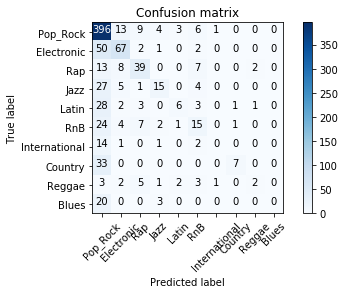

In [22]:
#WARNING: This code takes ~7 minutes to run
import xgboost as xgb
# setup random parameters for xgboost
param_trial = {}
param_trial['objective'] = 'multi:softprob' # use softprob to calculate logloss and later assign it to softmax within the function to calculate accuracy
param_trial['eta'] = 0.1 
param_trial['silent'] = 1
param_trial['max_depth'] = 6
param_trial['nthread'] = 4
param_trial['num_class'] = 10
param_trial['min_child_weight']= 1
param_trial['random_state'] = 1

modelfit_xgb(xgb, X_reduced, Y, param_trial, num_round = 50 ) #No Cross Validation
modelfit_xgb(xgb, X_reduced, Y, param_trial, num_round = 50, performCV = True, cv_folds = 5) #With Cross Validation

<font color = brown> **>> Result for Step 1:  It can be clearly seen that XGBoost outperforms other 3 models in both competitions even with random parameters. Therefore, we decide to go with XGBoost for the next steps.** </font>

### 4.2. Step 2: Fine-tuning Parameters 

<p style='text-align: justify;'>Apparently, there are several parameters to be tuned. In this experiment, we mainly followed the guidances from Cambridge, Spark [2017] and Aarshay, Jain [2016] for a XGBoost model. According to them, in an ideal world and infinite resources, it is possible to *“run a giant grid search with all the parameters together and find the optimal solution”*. However, it is impossible in our case, since resources are limited; thus, we had to pick some proper parameters and run them in a particular order to avoid surplus searches. Specifically, the order of tuning is as followings:</p>

- Max_depth and min_child_weight.
- Eta (aka learning rate)

Appendix 1 shows the meaning of each parameter that we used to tune the model.

**4.2.1. Tuning 1: max_depth, min_child_weight**

Here, we execute a grid search among 4 x 4 = 16 combinations of max_depth and min_child_weight value. Since we have two competitions, we run two models of Grid Search separately (1 for Accuracy, 1 for Logloss) with Cross Validation as the method for validation.

In [38]:
#WARNING: This code takes 75 mins.
import xgboost as xgb

param_tuned = {}
param_tuned['objective'] = 'multi:softprob' 
param_tuned['eta'] = 0.1
param_tuned['silent'] = 1
param_tuned['max_depth'] = 6
param_tuned['nthread'] = 4
param_tuned['num_class'] = 10
param_tuned['min_child_weight']= 1
param_tuned['random_state'] = 1

#the grid search being used:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,13,2)
    for min_child_weight in range(1,9,2)
]

best_params_merror = None
best_params_mlogloss = None
min_merror = float("Inf")
min_mlogloss = float("Inf")
dtrain = xgb.DMatrix(X_reduced, label=Y)

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={} :".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    param_tuned['max_depth'] = max_depth
    param_tuned['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        param_tuned,
        dtrain,
        num_boost_round=50,
        nfold=5,
        metrics={'merror', 'mlogloss'},
        early_stopping_rounds=10
    )
    
    # Update lowest error
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tError {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params_merror = (max_depth,min_child_weight)
        
    # Update lowest logloss    
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_mlogloss, boost_rounds+1))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params_mlogloss = (max_depth,min_child_weight)

print("Best params Accuracy: {}, {}, Error: {}".format(best_params_merror[0], best_params_merror[1], min_merror))
print("Best params Loglos: {}, {}, Logloss: {}".format(best_params_mlogloss[0], best_params_mlogloss[1], min_mlogloss))

CV with max_depth=6, min_child_weight=1 :


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
/Users/vinhngo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	Error 0.3655802 for 49 rounds
	Logloss 1.1565581999999999 for 50 rounds
CV with max_depth=6, min_child_weight=3 :
	Error 0.3628306 for 49 rounds
	Logloss 1.1455163999999998 for 50 rounds
CV with max_depth=6, min_child_weight=5 :
	Error 0.36603820000000004 for 40 rounds
	Logloss 1.1383914000000002 for 50 rounds
CV with max_depth=6, min_child_weight=7 :
	Error 0.360308 for 48 rounds
	Logloss 1.1384598000000001 for 50 rounds
CV with max_depth=8, min_child_weight=1 :
	Error 0.3710826 for 47 rounds
	Logloss 1.1754708 for 50 rounds
CV with max_depth=8, min_child_weight=3 :
	Error 0.3614548000000001 for 47 rounds
	Logloss 1.1475222 for 50 rounds
CV with max_depth=8, min_child_weight=5 :
	Error 0.3658092 for 49 rounds
	Logloss 1.1410833999999999 for 50 rounds
CV with max_depth=8, min_child_weight=7 :
	Error 0.35916240000000005 for 49 rounds
	Logloss 1.1307345999999998 for 50 rounds
CV with max_depth=10, min_child_weight=1 :
	Error 0.3697114 for 39 rounds
	Logloss 1.1848908000000002 for 50 rou

As a result, the search gave feedback that:
- For *Accuracy*: (max_depth = 12, min_child_weight = 5) gave the lowest error of 35.80%.
- For *Logloss*: (max_depth = 8, min_child_weight = 7) gave the lowest logloss of 1.1307.

Thus, from this point, we have to use 02 different parameter sets for 02 competitions. 

**4.2.2. Tuning 2: Eta**

First of all, we have to set a fixed value for *max_depth, min_child_weight* from the previous step. After that, we run XGBoost CV again for a set of 5 different *eta* value.

Since Accuracy and Logloss competition has diverged from the previous step, we have to tune *eta* separately.

In [39]:
##Tune ETA for Accuracy
#WARNING: This code takes ~25 mins.
import xgboost as xgb
param_tuned['max_depth'] = 12
param_tuned['min_child_weight']= 5

#the grid search being used:
gridsearch_params = [
    (eta)
    for eta in [0.1,0.15, 0.2, 0.25, 0.3]
]

best_params_merror = None
best_params_mlogloss = None
min_merror = float("Inf")
dtrain = xgb.DMatrix(X_reduced, label=Y)

for eta in gridsearch_params:
    print("CV with eta={} :".format(
                             eta))
    # Update our parameters
    param_tuned['eta'] = eta
    # Run CV
    cv_results = xgb.cv(
        param_tuned,
        dtrain,
        num_boost_round=50,
        nfold=5,
        metrics={'merror'}
    )
    # Update best MAE
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tError {} for {} rounds".format(mean_merror, boost_rounds+1))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params_merror = eta

print("Best params Accuracy: {}, Error: {}".format(best_params_merror, min_merror))

CV with eta=0.1 :


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	Error 0.3580164 for 50 rounds
CV with eta=0.15 :
	Error 0.35824599999999995 for 48 rounds
CV with eta=0.2 :
	Error 0.3559562 for 50 rounds
CV with eta=0.25 :
	Error 0.35366080000000005 for 48 rounds
CV with eta=0.3 :
	Error 0.356869 for 49 rounds
Best params Accuracy: 0.25, Error: 0.35366080000000005


In [41]:
##Tune ETA for Logloss
#WARNING: This code takes ~25 mins.
import xgboost as xgb
import copy

param_tuned_logloss = copy.copy(param_tuned)
param_tuned_logloss['max_depth'] = 8
param_tuned_logloss['min_child_weight']= 7

#the grid search being used:
gridsearch_params = [
    (eta)
    for eta in [0.1,0.15, 0.2, 0.25, 0.3]
]

best_params_mlogloss = None
min_mlogloss = float("Inf")
dtrain = xgb.DMatrix(X_reduced, label=Y)

for eta in gridsearch_params:
    print("CV with eta={} :".format(
                             eta))
    # Update our parameters
    param_tuned_logloss['eta'] = eta
    # Run CV
    cv_results = xgb.cv(
        param_tuned_logloss,
        dtrain,
        num_boost_round=50,
        nfold=5,
        metrics={'mlogloss'}
    )
    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_mlogloss, boost_rounds+1))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params_mlogloss = (eta)

print("Best params Loglos: {}, Logloss: {}".format(best_params_mlogloss, min_mlogloss))

CV with eta=0.1 :


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	Logloss 1.1307345999999998 for 50 rounds
CV with eta=0.15 :
	Logloss 1.1233397999999999 for 50 rounds
CV with eta=0.2 :
	Logloss 1.1266618 for 40 rounds
CV with eta=0.25 :
	Logloss 1.14003 for 32 rounds
CV with eta=0.3 :
	Logloss 1.1624222000000002 for 24 rounds
Best params Loglos: 0.15, Logloss: 1.1233397999999999


It can be seen that for Accuracy competition, best *eta* is **0.25**; meanwhile, best *eta* for Logloss is **0.15**.

In order to confirm the improvement of this step, we run XGBoost model again with the tuned parameters for each Competion as the code below:


Model Report: 
Without Cross Validation - Split Training/Validation set as 4:1 :
[0]	train-merror:0.3149	val-merror:0.461627
[1]	train-merror:0.242407	val-merror:0.423826
[2]	train-merror:0.195702	val-merror:0.436426
[3]	train-merror:0.161032	val-merror:0.420389
[4]	train-merror:0.134384	val-merror:0.395189
[5]	train-merror:0.115759	val-merror:0.400916
[6]	train-merror:0.094556	val-merror:0.399771
[7]	train-merror:0.077364	val-merror:0.395189
[8]	train-merror:0.06361	val-merror:0.389462
[9]	train-merror:0.051003	val-merror:0.386025
[10]	train-merror:0.040115	val-merror:0.376861
[11]	train-merror:0.030659	val-merror:0.373425
[12]	train-merror:0.024355	val-merror:0.366552
[13]	train-merror:0.019771	val-merror:0.368843
[14]	train-merror:0.014327	val-merror:0.363116
[15]	train-merror:0.010029	val-merror:0.360825
[16]	train-merror:0.008883	val-merror:0.364261
[17]	train-merror:0.007163	val-merror:0.363116
[18]	train-merror:0.006017	val-merror:0.364261
[19]	train-merror:0.004298	val-merror:

[35]	train-mlogloss:0.0837168+0.000993718	test-mlogloss:1.13781+0.0533323
[36]	train-mlogloss:0.0803934+0.000929257	test-mlogloss:1.13789+0.0541302
[37]	train-mlogloss:0.0773336+0.000931834	test-mlogloss:1.13817+0.0536404
[38]	train-mlogloss:0.0745428+0.00088934	test-mlogloss:1.1387+0.0550957
[39]	train-mlogloss:0.0718976+0.000803522	test-mlogloss:1.13922+0.0548923
[40]	train-mlogloss:0.0694884+0.000772364	test-mlogloss:1.1407+0.0553357
[41]	train-mlogloss:0.0671622+0.00074581	test-mlogloss:1.14172+0.0560802
[42]	train-mlogloss:0.0650412+0.00069632	test-mlogloss:1.14291+0.0560546
[43]	train-mlogloss:0.0630288+0.000660224	test-mlogloss:1.1436+0.0565238
[44]	train-mlogloss:0.0611656+0.000561662	test-mlogloss:1.14436+0.0573135
[45]	train-mlogloss:0.0593896+0.000508118	test-mlogloss:1.14559+0.0570988
[46]	train-mlogloss:0.0577798+0.000484067	test-mlogloss:1.14583+0.0568522
[47]	train-mlogloss:0.0562002+0.000415428	test-mlogloss:1.14687+0.0567735
[48]	train-mlogloss:0.0547504+0.000395537	te

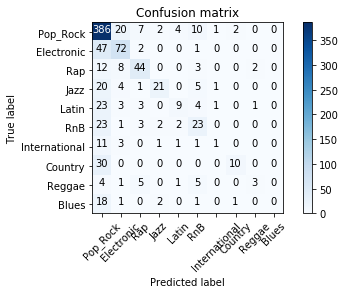

In [50]:
#Final param after tuning for Accuracy (Please Ignore Logloss Result))
#WARNING: The code take ~7 mins to run
param_tuned = {}
# use softmax multi-class classification
param_tuned['objective'] = 'multi:softprob'
# scale weight of positive examples
param_tuned['eta'] = 0.25
param_tuned['silent'] = 1
param_tuned['max_depth'] = 12
param_tuned['nthread'] = 4
param_tuned['num_class'] = 10
param_tuned['min_child_weight'] = 5
param_tuned['random_state'] = 1
param_tuned['subsample'] = 0.9

#Fitting model with tuned params
modelfit_xgb(xgb, X_reduced, Y, param_tuned, num_round = 50 ) #No Cross Validation
modelfit_xgb(xgb, X_reduced, Y, param_tuned, num_round = 50, performCV = True, cv_folds = 5) #With Cross Validation


Model Report: 
Without Cross Validation - Split Training/Validation set as 4:1 :
[0]	train-merror:0.33639	val-merror:0.455899
[1]	train-merror:0.289971	val-merror:0.426117
[2]	train-merror:0.268768	val-merror:0.405498
[3]	train-merror:0.244699	val-merror:0.387171
[4]	train-merror:0.226361	val-merror:0.379152
[5]	train-merror:0.209456	val-merror:0.379152
[6]	train-merror:0.193696	val-merror:0.37457
[7]	train-merror:0.184814	val-merror:0.373425
[8]	train-merror:0.173639	val-merror:0.376861
[9]	train-merror:0.165043	val-merror:0.37457
[10]	train-merror:0.158166	val-merror:0.367698
[11]	train-merror:0.146132	val-merror:0.371134
[12]	train-merror:0.135817	val-merror:0.368843
[13]	train-merror:0.125788	val-merror:0.367698
[14]	train-merror:0.116905	val-merror:0.372279
[15]	train-merror:0.107163	val-merror:0.375716
[16]	train-merror:0.102865	val-merror:0.373425
[17]	train-merror:0.095989	val-merror:0.368843
[18]	train-merror:0.086246	val-merror:0.364261
[19]	train-merror:0.080802	val-merror:

[30]	train-mlogloss:0.343151+0.00421357	test-mlogloss:1.13889+0.0378627
[31]	train-mlogloss:0.330305+0.00431599	test-mlogloss:1.13519+0.0376584
[32]	train-mlogloss:0.317505+0.00450253	test-mlogloss:1.13234+0.0371697
[33]	train-mlogloss:0.305432+0.00466961	test-mlogloss:1.1313+0.0372795
[34]	train-mlogloss:0.294174+0.00442749	test-mlogloss:1.12838+0.0382905
[35]	train-mlogloss:0.284007+0.00410135	test-mlogloss:1.12564+0.0390093
[36]	train-mlogloss:0.274441+0.00415849	test-mlogloss:1.12376+0.0391886
[37]	train-mlogloss:0.264794+0.00426553	test-mlogloss:1.12172+0.0391557
[38]	train-mlogloss:0.255708+0.00404099	test-mlogloss:1.11983+0.0395668
[39]	train-mlogloss:0.247219+0.00438085	test-mlogloss:1.11873+0.0400286
[40]	train-mlogloss:0.238595+0.00386756	test-mlogloss:1.1172+0.0402083
[41]	train-mlogloss:0.230841+0.00384916	test-mlogloss:1.11665+0.040549
[42]	train-mlogloss:0.22356+0.00350637	test-mlogloss:1.11547+0.0402539
[43]	train-mlogloss:0.216697+0.00339525	test-mlogloss:1.11474+0.0403

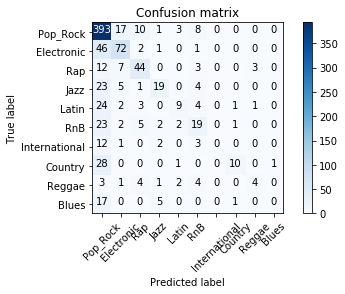

In [51]:
#Final param after tuning for Logloss (Please Ignore Accuracy Result)

#WARNING: The code take ~7 mins to run
param_tuned_logloss = {}
# use softmax multi-class classification
param_tuned_logloss['objective'] = 'multi:softprob'
# scale weight of positive examples
param_tuned_logloss['eta'] = 0.15
param_tuned_logloss['silent'] = 1
param_tuned_logloss['max_depth'] = 8
param_tuned_logloss['nthread'] = 4
param_tuned_logloss['num_class'] = 10
param_tuned_logloss['min_child_weight'] = 7
param_tuned_logloss['random_state'] = 1
param_tuned_logloss['subsample'] = 0.9

#Fitting model with tuned params
modelfit_xgb(xgb, X_reduced, Y, param_tuned_logloss, num_round = 50 ) #No Cross Validation
modelfit_xgb(xgb, X_reduced, Y, param_tuned_logloss, num_round = 50, performCV = True, cv_folds = 5) #With Cross Validation

It can clearly be seen that from the model with random parameters from **4.1. Step 1**, the new model with tuned parameters has improved:

- Without Cross Validation - Split Training/Validation set as 4:1:
   - Accuracy from 62.66% to 65.18%
   - Logloss from 1.155 to 1.112
- With Cross Validation - (CV 5 folds) :
   - Average Accuracy from 61.64 (+/- 3.78)% to **63.67 (+/- 4.42)%**
   - Average Logloss from 1.35 (+/- 0.48) to **1.26 (+/- 0.43)**
   
<font color =brown> **Result for Step 2: XGBoost model with parameters *param_tuned* (for Accuracy competition) and *param_tuned_logloss* (for Logloss competition)**

### 4.3. Step 3: A/B Testing between Oversampling/Imbalanced

As explained above, we activated Oversampling method by setting the parameter “oversampling” in our *modelfit_xgb* function with an oversampling size of 2000. The result can be seen here:

In [54]:
#For Accuracy:
#WARNING: This step takes ~10 mins
import xgboost as xgb
modelfit_xgb(xgb, X_reduced, Y, param_tuned, num_round = 50, performCV = True, cv_folds = 5, oversampling = True, oversampling_size = 2000) #With Cross Validation


Model Report: 
With Cross Validation - (CV 5 folds) :
Added  2000  random non pop-rock samples
	1. Accuracy:
[0]	train-merror:0.272788+0.0100131	test-merror:0.417724+0.0136754
[1]	train-merror:0.171735+0.00476578	test-merror:0.34685+0.00476409
[2]	train-merror:0.11669+0.00438625	test-merror:0.304416+0.00313491
[3]	train-merror:0.0833726+0.00193875	test-merror:0.273455+0.00417487
[4]	train-merror:0.0622348+0.00223985	test-merror:0.247995+0.00727568
[5]	train-merror:0.049112+0.00262103	test-merror:0.229764+0.00957775
[6]	train-merror:0.038661+0.00174607	test-merror:0.218136+0.00460115
[7]	train-merror:0.0305672+0.00170771	test-merror:0.208077+0.00470674
[8]	train-merror:0.024831+0.0014523	test-merror:0.197391+0.00731209
[9]	train-merror:0.0192126+0.00145075	test-merror:0.190791+0.0074194
[10]	train-merror:0.0150478+0.00163219	test-merror:0.182303+0.00701692
[11]	train-merror:0.012062+0.000590357	test-merror:0.176646+0.00584451
[12]	train-merror:0.0096258+0.00078575	test-merror:0.174918+

In [96]:
#For Logloss:
#WARNING: This step takes ~10 mins
import xgboost as xgb
modelfit_xgb(xgb, X_reduced, Y, param_tuned_logloss, num_round = 50, performCV = True, cv_folds = 5, oversampling = True, oversampling_size = 2000) #With Cross Validation


Model Report: 
With Cross Validation - (CV 5 folds) :
Added  2000  random non pop-rock samples
	1. Accuracy:
[0]	train-merror:0.319896+0.00486217	test-merror:0.437372+0.00714577
[1]	train-merror:0.250117+0.00623648	test-merror:0.387555+0.00657847
[2]	train-merror:0.205603+0.0061024	test-merror:0.349992+0.00443068
[3]	train-merror:0.174642+0.00398925	test-merror:0.32579+0.00820918
[4]	train-merror:0.152522+0.00406945	test-merror:0.304417+0.00753172
[5]	train-merror:0.136021+0.0039355	test-merror:0.289801+0.00765622
[6]	train-merror:0.121012+0.0052466	test-merror:0.280372+0.00838547
[7]	train-merror:0.108439+0.00459511	test-merror:0.273928+0.00657044
[8]	train-merror:0.0963774+0.00582049	test-merror:0.263085+0.0044831
[9]	train-merror:0.08793+0.00417529	test-merror:0.255698+0.00231548
[10]	train-merror:0.0810148+0.00474994	test-merror:0.24721+0.00613745
[11]	train-merror:0.0752002+0.00427693	test-merror:0.237623+0.00846295
[12]	train-merror:0.0700534+0.00343716	test-merror:0.233223+0.00

 For a Cross Validation of 5 folds, the results are:
 
 - For Accuracy competition: The average Accuracy is 82.33 **(+/- 10.89)**%
 - For Logloss competition: The average Logloss is 0.91 **(+/- 0.75)**

<p style='text-align: justify;'>At a glance, the average value might give a vague impression that oversampling increases the result significantly. Yet, this is where the Standard Deviation comes into play and affects our decision: Even though the average value is  better compared to **4.2. Step 2**, but the standard deviation is significantly high as well. This is a signal for overfitting, meaning that in some folds, the model can unexpectedly predict with high accuracy, but in some others, the results are not that good. Therefore, with a certain chance, the model can perform badly in the competition later. </p>

 <font color = brown> **>> Result from Step 3: In the scope of this project, we did not have enough resources to deal with this problem; therefore, we conclude that it is better to avoid this uncertainty by maintaining the dataset imbalanced as it is for both competition.**

### 4.4. Step 4: Model Optimization

With different number of features, we have attempted different number of features based on its ranking of importance from Section 2 in order to indentify the potential for model optimization before final prediction.

*Note: Warning ignored since it is irrelevant.*

With k = 100


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


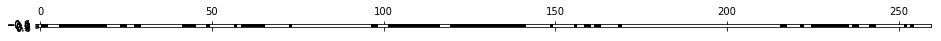

 --- The average Accuracy of this model is : 62.12 (+/- 3.48)%
With k = 150


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


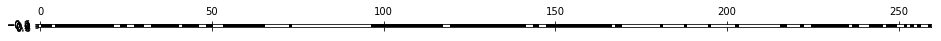

 --- The average Accuracy of this model is : 61.93 (+/- 3.55)%
With k = 200


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


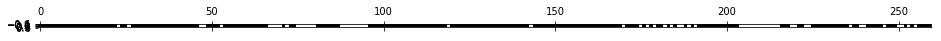

 --- The average Accuracy of this model is : 62.92 (+/- 4.04)%
With k = 250


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


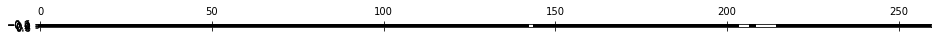

 --- The average Accuracy of this model is : 63.31 (+/- 4.09)%


In [68]:
#Select K Best for Accuracy Model:
#WARNING: This step takes ~25 mins
import xgboost as xgb

grid_check_k = [100,150,200,250]
for i in grid_check_k:
    print("With k = " + str(i))
    X_reduced_k = select_k_best(X_reduced,Y, i)
    xg_train_k = xgb.DMatrix(X_reduced_k, label=Y)
    bst = xgb.cv(param_tuned, xg_train_k, 50, nfold = 5, metrics = {'merror'})
    print(" --- The average Accuracy of this model is : %0.2f (+/- %0.2f)" % ((100 - bst['test-merror-mean'].mean() * 100), bst['test-merror-mean'].std() * 2 * 100) + "%")

With k = 100


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


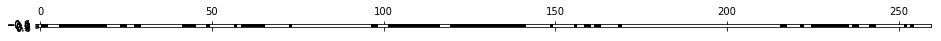

 --- The average Logloss: 1.28 (+/- 0.41)
With k = 150


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


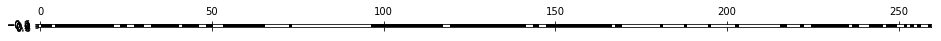

 --- The average Logloss: 1.27 (+/- 0.42)
With k = 200


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


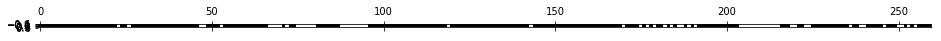

 --- The average Logloss: 1.26 (+/- 0.43)
With k = 250


/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


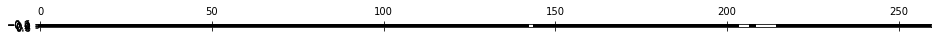

 --- The average Logloss: 1.26 (+/- 0.43)


In [67]:
#Select K Best for Logloss Model:
#WARNING: This step takes ~25 mins
import xgboost as xgb
grid_check_k = [100,150,200,250]
for i in grid_check_k:
    print("With k = " + str(i))
    X_reduced_k = select_k_best(X_reduced,Y, i)
    xg_train_k = xgb.DMatrix(X_reduced_k, label=Y)
    bst_proba = xgb.cv(param_tuned_logloss, xg_train_k, 50, nfold = 5,  metrics = {'mlogloss'})
    print(" --- The average Logloss: %0.2f (+/- %0.2f)" % (bst_proba['test-mlogloss-mean'].mean(), bst_proba['test-mlogloss-mean'].std() *2))

From the result above, we concluded that:

- **Accuracy Competition**: Even with different k, the modified model with 260 features ( see *Step 2: (63.67 (+/- 4.42)%* still performed the best. Thus, we still keep the model as it is.


- **Logloss Competition**: Starting from k = 200, the performance of the model does not change at all compared to the modified model with 260 features ( see *Step 2: also 1.26 (+/- 0.43)*). Thus, for Logloss competition, we decide to reduce the features to only 200 best features in order to improve the model efficiency.

Since the results do not change significantly, we do not execute those models again.

### 4.5. Step 5: Final Prediction

With the imported Test Set, we predicted as follow:

**1. Accuracy Competition:**
   - Reducing the feature size by dropping 4 meaningless columns [216, 217, 218, 219]
   - Using fine-tuned XGBoost model to predict. 
   - The Ytest set is a matrix of (N,1) dimension, where N is the number of row in the Test Set.
   - Encoding the 0 ... 9 label into 1 ... 10 and then writing file.
    
**2. Logloss Competition:**
   - Reducing the feature size by dropping 4 meaningless columns [216, 217, 218, 219]
   - Applying Select K Best model from Scikit-learn to select the best 200 features (explained from **Step 4**).
   - Using fine-tuned XGBoost model to predict. 
   - The Yprobatest set is a matrix of (N,10) dimension, where N is the number of row in the Test Set. Each column contains the class probability.
   - Encoding the 0 ... 9 label into 1 ... 10 and then writing file. 

In [104]:
#Prediction for Accuracy Competition:
Xtest = (pd.read_csv("test_data.csv", header = None)).values
Xtest_reduced = remove_columns(Xtest, [216,217,218,219])

xg_train_final = xgb.DMatrix(X_reduced, label=Y)
xg_test = xgb.DMatrix(Xtest_reduced)

## Get prediction:
bst = xgb.train(param_tuned, xg_train_final, 100)
Yprobatest_accu = bst.predict(xg_test).reshape(Xtest_reduced.shape[0], 10)
Ytest = np.zeros((Yprobatest_accu.shape[0],1))
for i in range(Yprobatest_accu.shape[0]):
    Ytest[i] = Yprobatest_accu[i].argmax()  

In [106]:
#Prediction for Logloss Competition:
Xtest = (pd.read_csv("test_data.csv", header = None)).values
Xtest_reduced = remove_columns(Xtest, [216,217,218,219])

panda_X = pd.DataFrame(X_reduced)
panda_Xtest = pd.DataFrame(Xtest_reduced)
panda_Y = pd.DataFrame(Y)

select = sklearn.feature_selection.SelectKBest(k=200)
selected_features = select.fit(panda_X, panda_Y )
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [panda_X.columns[i] for i in indices_selected]

Xtrain_final_logloss = panda_X[colnames_selected]
Xtest_final_logloss = panda_Xtest[colnames_selected]

#Get Prediction:
xg_test_logloss = xgb.DMatrix(Xtest_final_logloss)
xg_train_final_logloss = xgb.DMatrix(Xtrain_final_logloss, label=Y)
bst_proba = xgb.train(param_tuned_logloss, xg_train_final_logloss, 100)
Yprobatest = bst_proba.predict(xg_test_logloss).reshape(Xtest_reduced.shape[0], 10)

/Users/vinhngo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
#Write .csv File:
##Accuracy:
Ytest_decode= list(map(lambda x:x +1, Ytest))
with open("ytest_final_111.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Sample_id","Sample_label"])
    for i, value in enumerate(Ytest_decode):
        writer.writerow([i+1, int(value)])

##Logloss:
dflog = pd.DataFrame(Yprobatest)
dflog.index+=1
headers = ["Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9","Class_10"]
dflog.to_csv('yprobatest_final_111.csv', index = "TRUE", index_label = "Sample_id", header = headers)

### 4.6. Comparison with Results from Kaggle Competition (Public Leaderboard only)

Recall that the **Accuracy** performance of our model with the given training set:
- *Without Cross Validation - Split Training/Validation set as 4:1:*
  - Accuracy: 65.18%

- *With Cross Validation - (CV 5 folds):*
  - Average Accuracy: 63.67 (+/- 4.42)%

For latest confusion matrix, please refer to **Step 2**. 

For Kaggle Competition Public Leaderboard, applying above-mentioned methodology, we got the best submission for our model of ***66.632%***, which is not a surprise because it performs within the range of CV average accuracy. 

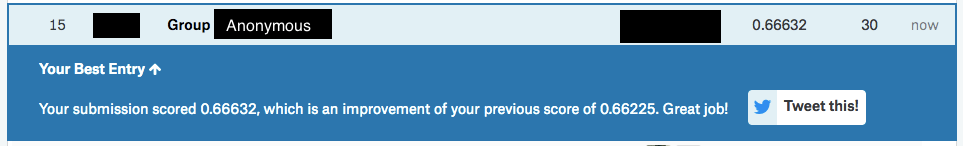

For **Logloss Competition**, we do not compare **Logloss** due to different N. However, we have the best performance on Kaggle Public Leaderboard as of **0.17211**.

## 5. Discussion/Conclusions

By analyzing the performance of XGBoost model and other supervised classifiers, we have made an attempt in dealing with a classification problem: **Music Genre Classification.** 

<div style="text-align: justify">In our opinion, the used models as well as approach have performed fairly well. That is, we managed to build two models which are able to classify songs into different genres. At a glance, they have beaten the benchmark for both Accuracy and Logloss Kaggle Public Competition. However, the results from our experiment are not exactly the same as the literatures that we based on. Precisely, XGBoost performed surprisingly better than the others, both in terms of accuracy and logloss. Therefore, it can be concluded that XGBoost is a suitable model for this multiclass classification problems. With some tuning, the performance has been improved significantly (+- 2%).</p>
<p></p>

<div style="text-align: justify">Apart from XGBoost, we also implemented Random Forests, Multinomial Naive Bayes and Multiclass Support Vector Machines but the results were not as good. However, Random Forests could be another promising model for Accuracy and Naive Bayes could be for Logloss Competition since they performed second best with a close gap to XGBoost. In overall, the result summary can be found below:</p>

<p></p>
![image4.png](attachment:image4.png)
<p></p>
<div style="text-align: justify">Additionally, it is worth pointing out the main issue of this given dataset: **Imbalance**. Indeed, Pop_Rock genre dominates the dataset, which results in a majority of classifications as Pop_Rock. Every confusion matrix from Section 4 can express this problem vividly. Nevertheless, as of the final performance on Kaggle competition, it is important to know if the test labels are also imbalanced or not - because if it is also imbalanced, it then does not make a big difference since the majority of the predicted label will belong to the dominating class anyway. </p>

**Doors for Future Research**

<div style="text-align: justify">*Imbalanced Dataset:* Throughout the journey, we identified the imbalanced dataset and tried to reduce its effect by oversampling method but the outcome was not significant: We ended up accepting the imbalance of the dataset due to the uncertainty of the cross validation result and limited resources. Hence, it is very interesting for us if there are following studies on other methods, for example undersampling. Plus, one way to improve the oversampling quality could be achieved by adding noise to the duplicates and thus decreasing the chance of overfitting.</p>

<div style="text-align: justify">*Size of dataset:* In addition, there would be more potential if there is a bigger dataset, in which one can apply other techniques - such as undersampling - to solve imbalanced dataset problem, or apply other deep learning method, such as neural networks from Tensorflow. </p>

<div style="text-align: justify">*Data Manufacturing:* Different possible ways of examining data can also be done to rescale or manipulate the data in order to make it more interpretable.</p>

<div style="text-align: justify">*Unsupervised Learning:* Clustering methods for data exploration may be another direction and give some novel insights for feature manufacturing. </p>
<p>./.</p>

## 6. References

Bilogur, A. (2018). "Undersampling and oversampling imbalanced data". Available from:
https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data [Accessed on 15 Oct 2018]

Bou-Rabee, A., Go, K. & Mohan, K. (2012). “Classifying the Subjective: Determining Genre of Music From Lyrics” . Available from:  http://cs229.stanford.edu/proj2012/BourabeeGoMohan-ClassifyingTheSubjectiveDeterminingGenreOfMusicFromLyrics.pdf [Accessed on 21 October 2018]

Brevard M., Kenyon K. (2016). “Artist Classifier”. Available from: 
https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a072.pdf [Accessed on 19 October 2018]

Brownlee, J. (2016). “ A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning”. Available from: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/. [Accessed on 15 Oct 2018]

Brownlee, J. (2016). “Naive Bayes for Machine Learning”. Available from: https://machinelearningmastery.com/naive-bayes-for-machine-learning/ [Accessed on 10 Oct 2018]

Cortes, C., Vapnik, V. N. (1995). "Support-vector networks". Machine Learning. 20 (3): 273–297. doi:10.1007/BF00994018.

Donges, N. (2018). “The Random Forest Algorithm”. Available from:
https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd [Accessed on 10 Oct 2018]

Gandhi, R. (2018). “Support Vector Machine — Introduction to Machine Learning Algorithms”. Available from: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47 [Accessed on 10 Oct 2018]

Harasymiv, V. (2015). “Lessons from 2MM machine learning models on Kaggle.com”. Available from:
https://www.linkedin.com/pulse/lessons-from-2mm-machine-learning-models-kagglecom-data-harasymiv/ [Accessed on 15 Oct 2018]

Li, S. (2018). “Multi-Class Text Classification with Scikit-Learn”. Available from:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f [Accessed on 12 October 2018]

Koehrsen, W. (2018). "A Feature Selection Tool for Machine Learning in Python". Available from: https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0 [ Accessed on 20 October 2018]

Neumayer, R. (n.d.). “Musical genre classification”.  Available from:
http://www.ifs.tuwien.ac.at/~neumayer/pubs/NEU04_wda.pdf
[Accessed 12 Oct 2018]

Pálmason, H., Jónsson, B., Schedl, M. & Knees, P. (2017). “Music Genre Classification Revisited: An In-Depth Examination Guided by Music Experts”. Available from:
http://cmmr2017.inesctec.pt/wp-content/uploads/2017/09/4_CMMR_2017_paper_71.pdf
[Accessed 15 Oct 2018]

“Scikit-learn documentation”, Available from:
http://scikit-learn.org/stable/documentation/ [Accessed on 10 Oct 2018]

“XGBoost Documentation” (n.d.). Available from:
 https://xgboost.readthedocs.io/en/latest/ [Accessed on 15 Oct 2018]

## Appendix

### Appendix 1: Explanation of used parameters in XGBoost model

- eta [default=0.3]:
  - Analogous to learning rate in GBM
  - Makes the model more robust by shrinking the weights on each step
- Typical final values to be used: 0.01-0.3
  - min_child_weight [default=1]
  - Defines the minimum sum of weights of all observations required in a child.
  - This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
  - Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
  - Too high values can lead to under-fitting hence, it should be tuned using CV.
- max_depth [default=6]
  - The maximum depth of a tree, same as GBM.
  - Used to control overfitting as higher depth will allow model to learn relations very specific to a particular sample. 
  - Should be tuned using CV.
  - Typical values: 3-10